# Implementing an Autoencoder

In this exercise, we would like to train on a popular face dataset, a sparse auto-encoder. We consider the simple two-layer autoencoder network:

\begin{align*}
\boldsymbol{z}_i &= \max(0,V \boldsymbol{x}_i + \boldsymbol{b}) & \text{(layer 1)}\\
\hat{\boldsymbol{x}}_i &= W \boldsymbol{z}_i + \boldsymbol{a} & \text{(layer 2)}
\end{align*}

where $W,V$ are matrices of parameters of the encoder and the decoder, and $\boldsymbol{b},\boldsymbol{a}$ are additional bias parameters. We seek to maximize the objective:

\begin{align*}
\min_{W} ~~
\underbrace{ \frac1N \sum_{i=1}^N \| \boldsymbol{x}_i - \hat{\boldsymbol{x}}_i \|^2}_{\text{reconstruction}}
+ \lambda \cdot
\underbrace{\frac1N \sum_{i=1}^N \|\boldsymbol{z}_i\|_1}_{\text{sparsity}}
+ \epsilon \cdot
\underbrace{\sum_{j=1}^h\Big( \frac1N \sum_{i=1}^N [\boldsymbol{z}_i]_j \Big)^{-1}}_{\text{"entropy"}}
+ \eta \cdot \!\!\!\!
\underbrace{\phantom{\Bigg[}\|W\|_F^2 \phantom{\Bigg[}}_{\text{regularization}}
\end{align*}

The objective is composed of four terms: The reconstruction term is the standard mean square error between the data points and their reconstructions. The sparsity term applies a l1-norm to drive activation to zero in the representation. The "entropy" term that ensures that at least a few examples activate each source dimension. The regularization term ensures that the sparsity term remains effective.

## Loading the dataset

We first load the Labeled Faces in the Wild (LFW) dataset. The LFW is a popular face recognition dataset which is readily available from scikit learn. When loading the dataset, we specify some image downscaling in order to limit the computation resources. The following code visualizes a few images that we have extracted from the LFW dataset.

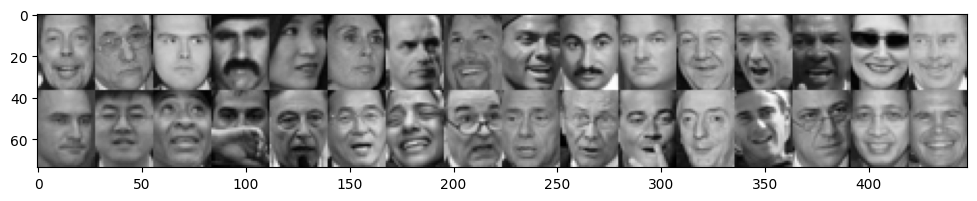

In [1]:
import sklearn,sklearn.datasets
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

data = sklearn.datasets.fetch_lfw_people(resize=0.3)['images']

plt.figure(figsize=(12,2.5))
plt.imshow(data[:32].reshape(2,16,37,28).transpose(0,2,1,3).reshape(2*37,16*28),cmap='gray')
plt.show()

## Implementing the autoencoder (20 P)

We now would like to train an autoencoder on this data. As a first step, we standardize the data, which is a usual step before training a ML model. (Note that contrarily to other component analyses such as ICA, the data does not need to be whitened.)

In [2]:
X = data.reshape(len(data),-1)
X = X - X.mean(axis=0)
X = X / X.std()

To learn the autoencoder, we need to optimize the objective function above. This can be done using by gradient descent, or some enhanced gradient-based optimizer such as Adam. Because a manual computation of the gradients can be difficult and error-prone, we will make use of automatic differentiation readily provided by the PyTorch software. PyTorch uses its own structures for storing the data and the model parameters. (You can consult the tutorials at https://pytorch.org/tutorials/ to learn the basics.)

We first convert the data into a PyTorch tensor.

In [3]:
import torch

X  = torch.FloatTensor(X)

Recall that the four terms that compose the objective function are given by:
\begin{align*}
\text{rec} &= \frac1N \sum_{i=1}^N \| \boldsymbol{x}_i - \hat{\boldsymbol{x}}_i \|^2 &
\text{spa} &= \Big(\frac1N \sum_{i=1}^N \|\boldsymbol{z}_i\|_1\Big)\\
\text{ent} &= \sum_{j=1}^h\Big( \frac1N \sum_{i=1}^N [\boldsymbol{z}_i]_j \Big)^{-1} &
\text{reg} &= \|W\|_F^2
\end{align*}

**Task:**

 * **Create the function `get_objective_terms` that computes these terms.**

The function receives as input:

 * A `FloatTensor` `X` of size $m \times d$ containing a data minibatch of $m$ examples.
 * A `FloatTensor` `V` of size $d \times h$ containing the weights of the encoder.
 * A `FloatTensor` `W` of size $h \times d$ containing the weights of the decoder.
 * A `FloatTensor` `b` of size $h$ containing the bias of the encoder.
 * A `FloatTensor` `a` of size $d$ containing the bias of the decoder.
 
In your function, the parameter $\epsilon$ can be hardcoded to 0.01. The function should return the four terms (`rec`, `spa`, `ent`, `reg`) of the objective. (These terms will be merged later on in a single objective function.) While implementing the `get_objective_terms` function, make sure to use PyTorch functions so that the gradient information necessary for automatic differentiation is retained. For example, converting arrays to numpy will not work as this will remove the gradient information.

In [5]:
def get_objective_terms(X, V, W, b, a):
    N_X = X.shape[0]

    Z = torch.mm(X, V) + b
    Z[Z < 0] = 0

    N_Z = Z.shape[0]

    X_hat = torch.mm(Z, W) + a

    norm = torch.dist(X, X_hat, p=2)
    rec = (norm ** 2) / N_X

    one_norm = torch.dist(Z, torch.zeros_like(Z), p=1)
    spa = one_norm / N_Z

    Z_mean_row = torch.mean(Z, axis=0)
    ent = torch.sum(1 / Z_mean_row)

    reg = torch.norm(W) ** 2

    return rec, spa, ent, reg


## Training the autoencoder

Now that the terms of the objective function have been implemented, the model can be trained to minimize the objective. The code below calls the function `get_objective_terms` repeatedly (once per iteration). Automatic differentiation is used to compute the gradient, and we use Adam (a state-of-the-art optimizer for neural networks) to optimize the parameters. The number of units in the representation is hard-coded to $h=400$, and we use the parameter $\eta=1$ for the regularizer.

In [7]:
import torch.optim
import torch.nn
import numpy

def train(X,lambd=0):
    
    d = X.shape[1]
    h = 400
    
    eps = 0.01 * lambd # hard-coded parameter
    eta = 1 * lambd    # hard-coded parameter
    
    V = torch.nn.Parameter(d**-.5*torch.randn([d,h]))
    W = torch.nn.Parameter(torch.zeros([h,d]))
    b = torch.nn.Parameter(torch.zeros([h]))
    a = torch.nn.Parameter(torch.zeros([d]))
    
    optimizer = torch.optim.Adam((V,W,b,a), lr=0.0001)
    
    print('%7s %8s %8s %8s %8s'%('nbit','rec','spa','ent','reg'))
    
    for i in range(0,10001):
        
        optimizer.zero_grad()
        
        x= X[numpy.random.permutation(len(X))[:100]]
        
        rec,spa,ent,reg = get_objective_terms(x,V,W,b,a)
        
        (rec + lambd*spa + eps*ent + eta*reg).backward()
        
        if i%1000 == 0: print('%7d %8.2f %8.2f %8.2f %8.2f'%(i,rec.data,spa.data,ent.data,reg.data))
        
        optimizer.step()

    return V,W,b,a

### Dense Autoencoder

We first train an autoencoder with parameter $\lambda=0$, that is, a standard autoencoder without sparsity. The parameters of the learn autoencoder are stored in the variables `V`, `W`, `b`, `a`. Running the code may take a few minutes. You may temporarily reduce the number of iterations when testing your implementation.

In [8]:
V1,W1,b1,a1 = train(X,lambd=0)

   nbit      rec      spa      ent      reg
      0   915.31   142.39  1186.41     0.00
   1000   140.01   432.34   389.25    49.31
   2000    95.01   439.32   375.91    77.70
   3000    82.41   444.93   377.12    98.08
   4000    69.24   445.30   383.21   115.05
   5000    68.07   429.45   388.09   130.37
   6000    57.80   427.53   397.71   145.00
   7000    50.79   415.01   405.57   159.92
   8000    47.40   404.66   417.28   175.84
   9000    42.14   410.12   413.84   193.66
  10000    36.12   421.20   406.63   213.80


We observe that the reconstruction term decreases strongly, indicating that the autoencoder becomes increasingly better at reconstructing the data. The sparsity term, however, increases, indicating that the standard autoencoder does not learn a sparse representation.

### Sparse Autoencoder

We now would like to train a sparse autoencoder. For this, we set the sparsity parameter to $\lambda=1$ and re-run the training procedure. We store the learned parameters in another set of variables.

In [9]:
V2,W2,b2,a2 = train(X,lambd=1)

   nbit      rec      spa      ent      reg
      0  1089.73   155.07  1099.79     0.00
   1000   211.03   176.99  1200.65    78.36
   2000   176.38   160.97  1613.80    76.37
   3000   162.94   156.61  1915.61    73.35
   4000   163.83   156.56  1926.77    71.57
   5000   140.41   149.90  2120.65    70.84
   6000   146.20   159.50  1974.13    70.06
   7000   143.42   152.87  2122.91    69.74
   8000   154.14   161.60  1860.77    69.58
   9000   142.90   149.08  2085.49    69.80
  10000   134.85   146.12  2160.15    69.50


We observe that setting the parameter $\lambda$ to a non-zero keeps the sparsity term low, which indicates that a sparser representation has been learned. In turn, we also loose a bit of reconstruction accuracy compared to the original autoencoder. This can be expected since the sparsity imposes additional constraints on the solution.

## Analyzing autoencoder sparsity (10 P)

As a first analysis, we would like to verify how truly sparse the representation we have learned is.

**Task:**

 * **Create a line plot where the two lines represents all activations (for the 25 first examples in the dataset) sorted from largest to smallest of the respective autoencoder models.**

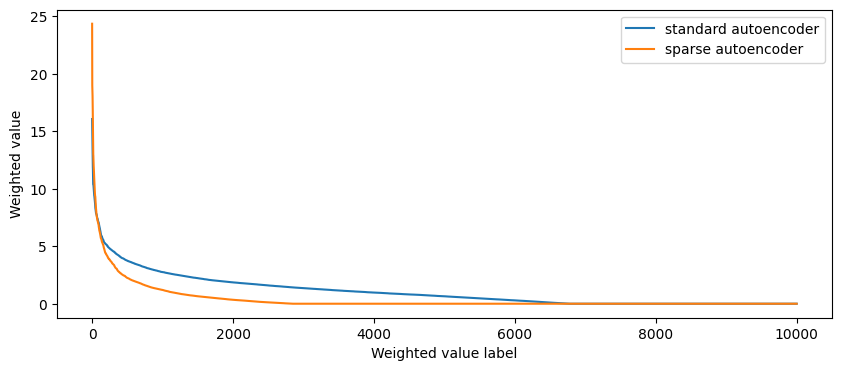

In [11]:
def plot_sparsity(X, V1, V2, b1, b2):
    Z_standard = torch.mm(X, V1) + b1
    Z_standard[Z_standard < 0] = 0
    Z_standard = Z_standard.reshape(-1).sort(descending=True)[0]
    Z_standard = Z_standard.detach().numpy()

    Z_sparse = torch.mm(X, V2) + b2
    Z_sparse[Z_sparse < 0] = 0
    Z_sparse = Z_sparse.reshape(-1).sort(descending=True)[0]
    Z_sparse = Z_sparse.detach().numpy()

    plt.figure(1, figsize=(10, 4))
    plt.plot(Z_standard, label="standard autoencoder")
    plt.plot(Z_sparse, label="sparse autoencoder")
    plt.ylabel("Weighted value")
    plt.xlabel("Weighted value label")
    plt.legend()
    
plot_sparsity(X[:25], V1, V2, b1, b2)

We observe that the sparse autoencoder has a much larger proportion of weights that are close to zero. Hence, the our model has learned a sparse representation. One possible use of sparsity is to compress the data while retaining most of the information.

## Inspecting the representation (10 P)

As a second analysis, we would like to visualize what the decoder has learned.


**Task:**

 * **Write code that displays the first 64 decoding filters of the two models, in a similar mosaic format as it was used above to display some examples from the dataset.**

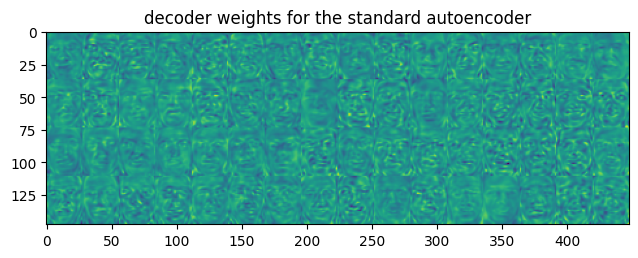

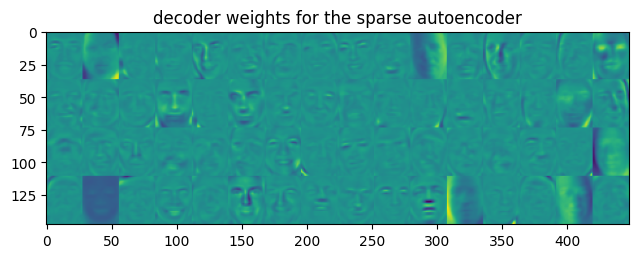

In [12]:
def view_decoder(W1, W2):
    plt.figure(2, figsize=(12, 2.5))
    plt.imshow(
        W1[:64].detach().numpy().reshape(4, 16, 37, 28).transpose(0, 2, 1, 3).reshape(4 * 37, 16 * 28)
    )
    plt.title("decoder weights for the standard autoencoder")

    plt.figure(3, figsize=(12, 2.5))
    plt.imshow(
        W2[:64].detach().numpy().reshape(4, 16, 37, 28).transpose(0, 2, 1, 3).reshape(4 * 37, 16 * 28)
    )
    plt.title("decoder weights for the sparse autoencoder")
    
view_decoder(W1, W2)

We observe that the filters of the standard autoencoder are quite difficult to interpret, whereas the sparse autoencoder produces filters with a stronger focus a single facial or background features such as the mouth, the nose, the bottom left/right corners, or the overall lighting condition. The features of the sparse autoencoder are also more interpretable for a human.